In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import  asdict
import pickle

import sys
sys.path.insert(0,'../../') # just for jupyter  notebook
from stochvolmodels.data.test_option_chain import get_btc_test_chain_data
from stochvolmodels.utils.funcs import transform_from_tfcomplex128_to_np
from datetime import datetime


2024-01-04 13:50:59.509432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def jump_compensators(nu, eta, side):
    if side == 'p':
        return np.exp(nu)/(1-eta)-1
    elif side == 'm':
        return np.exp(nu)/(1+eta)-1

positive_jump_compensator = lambda nu_p, eta_p: jump_compensators(nu_p, eta_p, 'p')
negative_jump_compensator = lambda nu_m, eta_m: jump_compensators(nu_m, eta_m, 'm')


In [3]:
P_params = pd.read_csv('P_params.csv', index_col=0)
P_params.index = pd.Series(P_params.index).apply(lambda x: x[:10])
P_params.index = pd.to_datetime(P_params.index)

with open("Q_results_refined.pickle", "rb") as f: 
    Q_results = pickle.load(f)
    
Q_params = dict()
for date in Q_results:
    d = asdict(transform_from_tfcomplex128_to_np(Q_results[date]['measure_change_results']))
    
    d['is_pos_jump'] = Q_results[date]['is_pos_jump']
    d['is_neg_jump'] = Q_results[date]['is_neg_jump']
    if Q_results[date]['MAPE'] <= 2:
        Q_params[date] = d
    
Q_params = pd.DataFrame(Q_params).T
Q_params.index = pd.to_datetime(Q_params.index)
Q_params = Q_params.astype(np.float64)

In [4]:
def gen_jumps_premia(Q_params, P_params):
    pjp = Q_params.lambda_p * positive_jump_compensator(Q_params.nu_p, Q_params.eta_p) - P_params.lambda_p_right * positive_jump_compensator(P_params.nu_p, P_params.eta_p)
    njp = Q_params.lambda_m * negative_jump_compensator(Q_params.nu_m, Q_params.eta_m) - P_params.lambda_m_right * negative_jump_compensator(P_params.nu_m, P_params.eta_m)
    # pjp*= Q_params.sigma
    # njp*= Q_params.sigma

    pjp.index = pd.to_datetime(pjp.index)
    njp.index = pd.to_datetime(njp.index)
    pjp.name = 'pjp'
    njp.name = 'njp'
    return pjp.dropna(), njp.dropna()

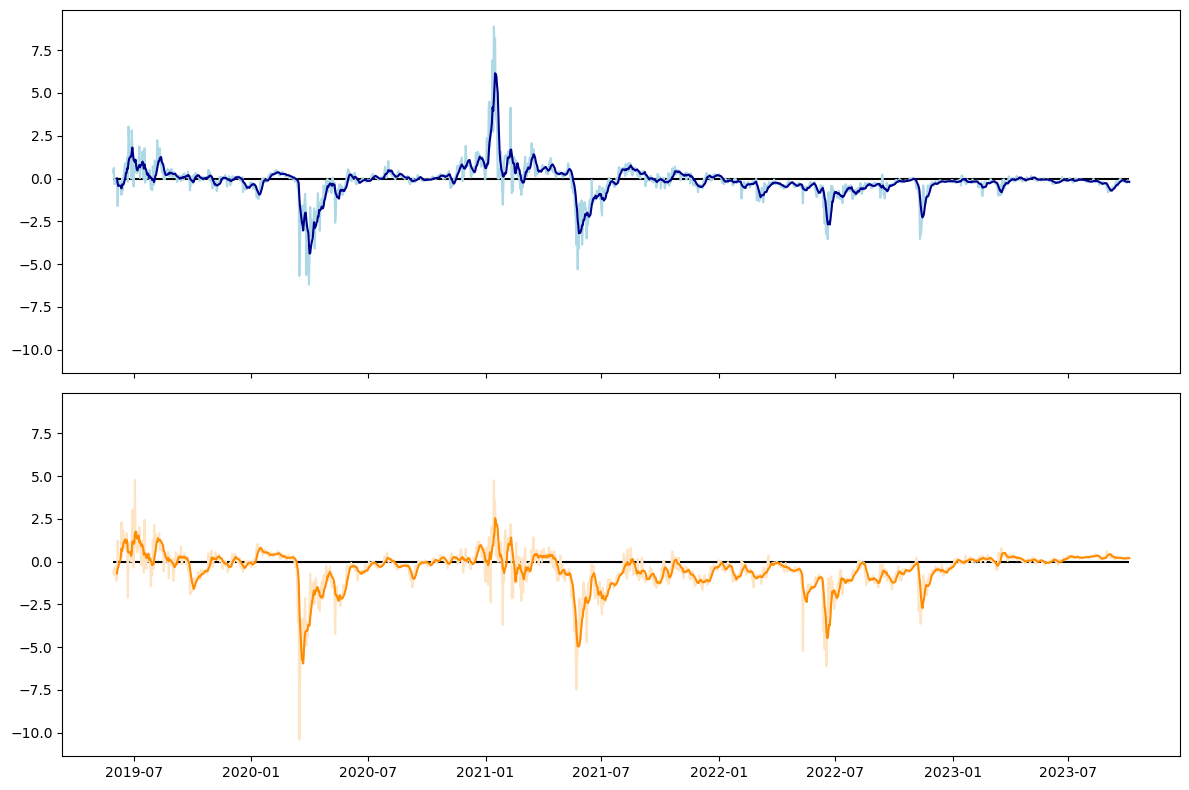

In [5]:
pjp, njp = gen_jumps_premia(Q_params, P_params)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,8))

axs[0].plot(pjp.rolling(7).mean(), color='darkblue')
axs[0].plot(pjp, color='lightblue', zorder=-10)
axs[0].hlines(0, xmax=pjp.index.max(), xmin=pjp.index.min(), color='black', zorder=-11)

axs[1].plot(njp.rolling(7).mean(), color='darkorange')
axs[1].plot(njp, color='bisque', zorder=-10)
axs[1].hlines(0, xmax=pjp.index.max(), xmin=pjp.index.min(), color='black', zorder=-11)
plt.tight_layout()

plt.savefig('jumps_premia.png', transparent=True)

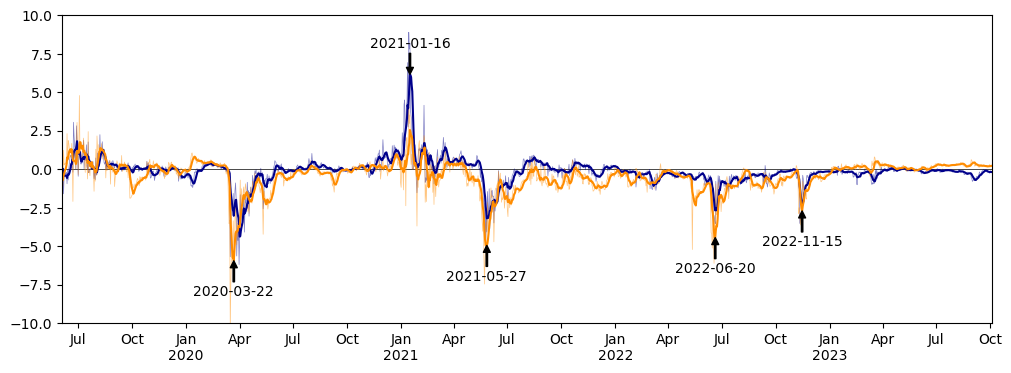

In [68]:
pjp, njp = gen_jumps_premia(Q_params, P_params)


plt.figure(figsize=(12,4))
plt.plot(pjp.rolling(7).mean(), color='darkblue')
plt.plot(pjp, color='darkblue', zorder=-10, alpha=0.5, linewidth=.5)
# plt.fill_between(pjp.index, 0, pjp.rolling(7).mean(), alpha=0.05, color='darkblue', zorder=-20)

plt.plot(njp.rolling(7).mean(), color='darkorange')
plt.plot(njp, color='darkorange', zorder=-10, alpha=0.5, linewidth=.5)
# plt.fill_between(njp.index, 0, njp.rolling(7).mean(), alpha=0.08, color='darkorange', zorder=-20)


_min = min([min(pjp), min(njp)])
_max = max([max(pjp), max(njp)])

# plt.vlines(['2020-01-16', '2020-11-08', '2022-01-05', '2023-01-09'],
#            -20, 20, zorder=-40, color='black', alpha=1, linewidth=0.5)

plt.hlines([0], pjp.index[0], pjp.index[-1], zorder=-60, color='black', alpha=1, linewidth=0.5)

y = njp.rolling(7).mean()['2020-03-22']
x = datetime(2020,3,22)
plt.annotate(text='2020-03-22', xy=(x,y), xytext=(x,y-2),
             va='center', ha='center', color='black', alpha=1, zorder=100,
             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))

y = pjp.rolling(7).mean()['2021-01-16']
x = datetime(2021,1,16)
plt.annotate(text='2021-01-16', xy=(x,y), xytext=(x,y+2),
             va='center', ha='center', color='black', alpha=1, zorder=100,
             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))

y = njp.rolling(7).mean()['2021-05-27']
x = datetime(2021,5,27)
plt.annotate(text='2021-05-27', xy=(x,y), xytext=(x,y-2),
             va='center', ha='center', color='black', alpha=1, zorder=100,
             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))

y = njp.rolling(7).mean()['2022-06-20']
x = datetime(2022,6,20)
plt.annotate(text='2022-06-20', xy=(x,y), xytext=(x,y-2),
             va='center', ha='center', color='black', alpha=1, zorder=100,
             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))

y = njp.rolling(7).mean()['2022-11-15']
x = datetime(2022,11,15)
plt.annotate(text='2022-11-15', xy=(x,y), xytext=(x,y-2),
             va='center', ha='center', color='black', alpha=1, zorder=100,
             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))

plt.ylim((-10, 10))
xticks_loc = []
xticks = []
for Y in [2019, 2020, 2021, 2022, 2023]:
    for m in [1,4,7,10]:
        d = datetime(Y, m, 1)
        xticks_loc.append(d)
        
        month = d.strftime('%b')

        if m==1:
            s = month + '\n' + d.strftime('%Y')
        else:
            s = month
        xticks.append(s)

plt.xticks(xticks_loc, xticks)
plt.xlim(('2019-06-04', '2023-10-05'))
plt.savefig('jumps_premia.pdf', transparent=True, bbox_inches = 'tight', dpi=1000)

In [69]:
# VAR
from statsmodels.tsa.api import VAR

In [124]:
pjp_r = pjp/pjp.shift(1)
njp_r = njp/njp.shift(1)

In [200]:
data_for_VAR = pd.merge(P_params.returns*100, pjp, left_index=True, right_index=True)
data_for_VAR = pd.merge(data_for_VAR, njp, left_index=True, right_index=True)
data_for_VAR = data_for_VAR.loc[np.isnan(data_for_VAR).sum(axis=1) == 0]

2


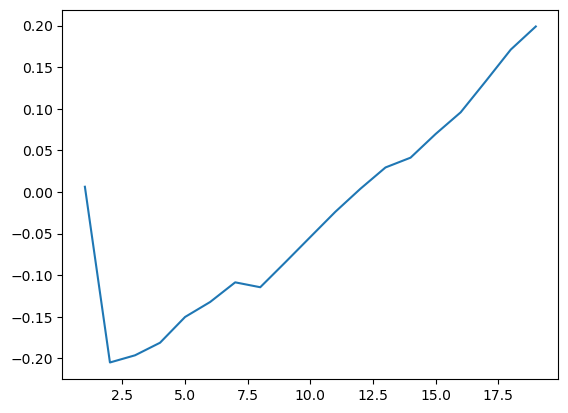

In [201]:
# Search for best lag
BIC = dict()
for k in range(1,20):
    model = VAR(data_for_VAR)
    results = model.fit(k)
    BIC[k]=results.bic
BIC = pd.Series(BIC)
plt.plot(BIC)
k = BIC.idxmin()
print(k)

In [202]:
model = VAR(data_for_VAR)
results = model.fit(k)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     22:18:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.204985
Nobs:                     1586.00    HQIC:                 -0.249665
Log likelihood:          -6511.38    FPE:                   0.758756
AIC:                    -0.276075    Det(Omega_mle):        0.748798
--------------------------------------------------------------------
Results for equation returns
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.109129         0.099329            1.099           0.272
L1.returns        -0.093447         0.025423           -3.676           0.000
L1.pjp             0.596277         0.201052            2.966         

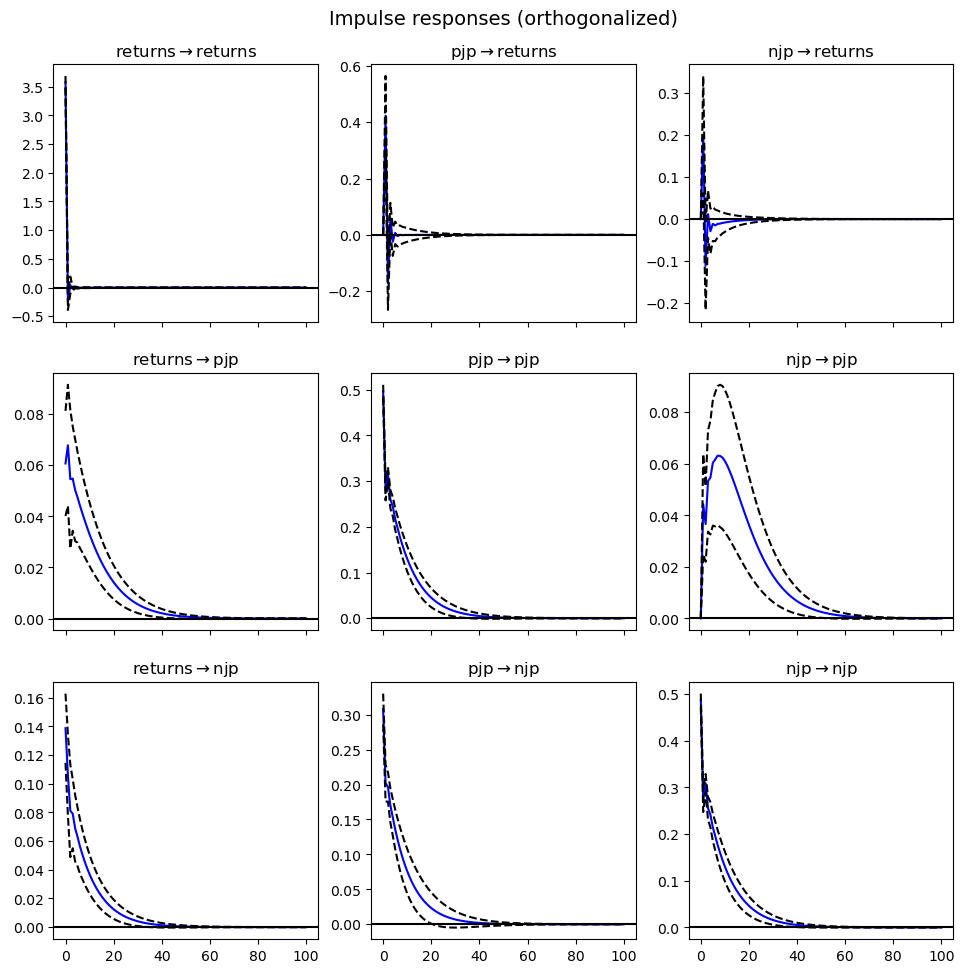

In [203]:
irf = results.irf(100)
irf.plot(orth=True, figsize=(10,10), signif=0.1)
# plt.show()
plt.savefig('IRF.pdf', transparent=True)

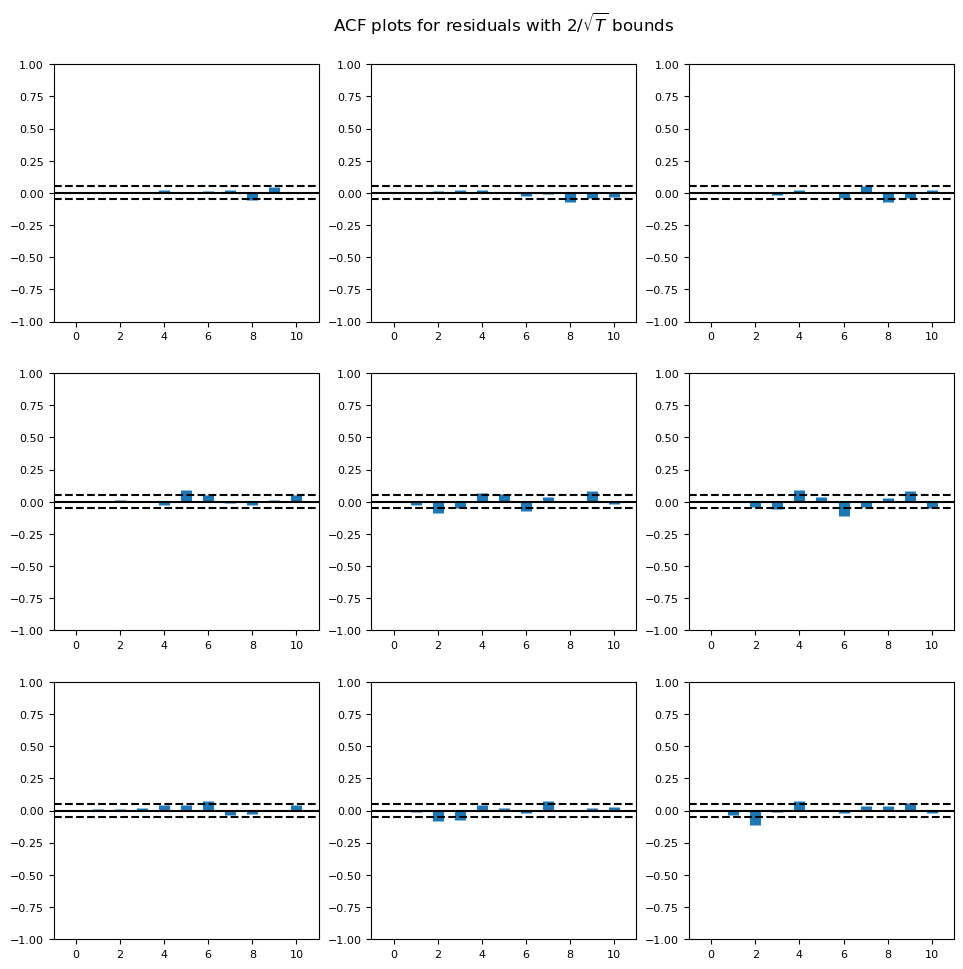

In [186]:
results.plot_acorr()
plt.show()

In [33]:
import yfinance as yf

SP500 = yf.Ticker("^GSPC") # SP500
SP500 = SP500.history(period="max")

HSI = yf.Ticker("^HSI") # Hang seng index
HSI = HSI.history(period="max")

NI225 = yf.Ticker("^N225") # Nikkei 225
NI225 = NI225.history(period="max")

DAX = yf.Ticker("^GDAXI") # DAX, German
DAX = DAX.history(period="max")

CAC40 = yf.Ticker("^FCHI") # CAC 40, French
CAC40 = CAC40.history(period="max")

FTSE100 = yf.Ticker("^FTSE") # FTSE, English
FTSE100 = FTSE100.history(period="max")

BTC = yf.Ticker("BTC-USD") # BTC
BTC = BTC.history(period="max")

ETH = yf.Ticker("ETH-USD") # ETH
ETH = ETH.history(period="max")

EEM = yf.Ticker("EEM") # iShares MSCI Emerging Markets ETF, https://www.msci.com/documents/10199/c0db0a48-01f2-4ba9-ad01-226fd5678111
EEM = EEM.history(period="max")

WSML = yf.Ticker("WSML.L") # iShares MSCI World Small Cap UCITS ETF (WSML.L), https://finance.yahoo.com/quote/WSML.L/
WSML = WSML.history(period="max")

In [152]:
Closing_prices = dict()

data_names =  ['SP500', 'HSI', 'NI225', 'FTSE100', 'DAX', 'CAC40', 'EEM', 'WSML', 'BTC', 'ETH']
for i, data in enumerate([SP500, HSI, NI225, FTSE100, DAX, CAC40, EEM, WSML, BTC, ETH]):
    _close = data.Close
    _close.index = pd.Series(data.index).apply(lambda x: x.strftime('%Y-%m-%d'))
    Closing_prices[data_names[i]] = _close

In [153]:
df = pd.DataFrame(Closing_prices)
df = df.dropna()
log_returns = np.log(df/df.shift(1)).dropna()

In [162]:
df.index

Index(['2018-03-27', '2018-03-28', '2018-03-29', '2018-04-03', '2018-04-04',
       '2018-04-06', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12',
       ...
       '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
       '2023-12-21', '2023-12-22', '2023-12-27', '2023-12-28', '2023-12-29'],
      dtype='object', name='Date', length=1273)

In [154]:
size_grid = [0.04, 0.06, 0.08, 0.1, .2, .5]
cdfs = []
for s in size_grid:
    cdfs.append((np.abs(log_returns) >= s).sum())

In [155]:
cdfs = pd.DataFrame(cdfs)

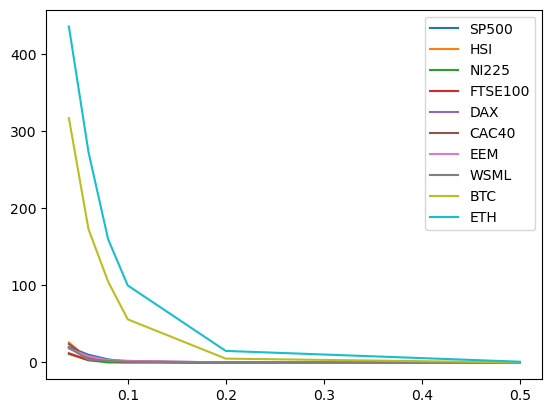

In [156]:
for c in cdfs.columns:
    plt.plot(size_grid, cdfs.loc[:,c], label=c)
plt.legend()
    

In [157]:
cdfs.index = size_grid

In [160]:
print(cdfs.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  SP500 &  HSI &  NI225 &  FTSE100 &  DAX &  CAC40 &  EEM &  WSML &  BTC &  ETH \\
\midrule
0.04 &     20 &   26 &     11 &       12 &   20 &     24 &   18 &    19 &  317 &  436 \\
0.06 &     10 &    4 &      3 &        3 &    4 &      6 &    8 &     4 &  173 &  273 \\
0.08 &      4 &    1 &      0 &        2 &    3 &      3 &    3 &     2 &  105 &  160 \\
0.10 &      1 &    0 &      0 &        1 &    2 &      1 &    2 &     1 &   56 &  100 \\
0.20 &      0 &    0 &      0 &        0 &    0 &      0 &    0 &     0 &    5 &   15 \\
0.50 &      0 &    0 &      0 &        0 &    0 &      0 &    0 &     0 &    0 &    1 \\
\bottomrule
\end{tabular}

